# 4.3.  Gradient-Based Saliency Maps for Neural Network Interpretability
### Alex Gagliano (gaglian2@mit.edu)
### August 2nd, 2023
References and resources for additional reading:
* [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034), Simonyan et al., 2013 - implemented [here](https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb).
* [Visualizing and Understanding Convolutional Networks](http://arxiv.org/abs/1311.2901), Zeiler et al. (2013) 
* [Striving for Simplicity - The All Convolutional Net](http://arxiv.org/abs/1412.6806), Springenberg et al. (2015)
* [https://github.com/wangyongjie-ntu/Awesome-explainable-AI]().


Saliency maps are potentially the most commonly-used approaches for pixel attribution in image-based neural networks (pixel attribution = sensitivity maps = saliency maps). Introduced in their first form by Simonyan et al. (2013), they were first generated by calculating the gradients of the loss function for a given output class with respect to the image pixels (holding the weights fixed). They're straightforward to calculate, so let's do that now with the same galaxy classification model we trained in the previous notebooks.

## 4.3.1. Saliency Maps for Galaxy Classification

In [526]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

In [527]:
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(3, 20, kernel_size=5),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(720, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 3*16*15)
        x = self.fc_layers(x)
        return x

model = Net().to(device)

#load the model from the SHAP tutorial!
model.load_state_dict(torch.load('./galaxyCNN.pth'))

<All keys matched successfully>

In [528]:
GalaxyClasses = {0:'Ellip.', 1:'Spiral', 2:'Irreg.'}

def vanilla_saliency(input, model):
    # We don't need gradients with respect to the weights, so we can turn these off
    for param in model.parameters():
        param.requires_grad = False
    
    # Set model to evaluation mode
    model.eval()

    # We want to calculate gradients of the input,
    # so set requires_grad to True for input 
    input.requires_grad = True
    
    # Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    
    # Backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    slc = input.grad[0]
    return slc.numpy()

def plot_saliency(input, saliency_set, include_shap=False):
    ncol = len(saliency_set)+1
    
    fig = plt.figure()
    if include_shap:
        ncol += 1
    grid = ImageGrid(fig, 111,
                    nrows_ncols = (1,ncol),
                    axes_pad = 0.05
                    )
    
    grid[0].imshow(input.detach().numpy().squeeze(0))
    grid[0].axis('off')
    grid[0].set_title('Input Image')

    mapTitles = ['Basic', 'Guided', 'SmoothGrad', 'SHAP']
    for i in np.arange(len(saliency_set)):
        slc = saliency_set[i]
        
        #normalize to [0..1]
        slc = np.abs(slc)
        slc = (slc - slc.min())/(slc.max()-slc.min())
        
        imc = grid[i+1].imshow(slc, cmap='hot',  vmin=0, vmax=1)
        grid[i+1].axis('off')
        grid[i+1].set_title(mapTitles[i])  
    if include_shap:
        return grid
    else:
        plt.show()

In [529]:
batch_size = 8
galaxyPath = 'data/galaxy/'

data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])

train = torchvision.datasets.ImageFolder(os.path.join(galaxyPath, 'train'), transform = data_transform)
test = torchvision.datasets.ImageFolder(os.path.join(galaxyPath, 'test'), transform = data_transform)

train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test, shuffle=True, batch_size=batch_size)

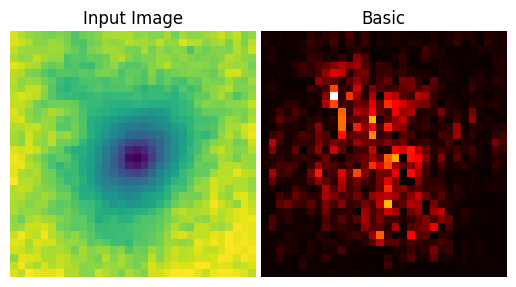

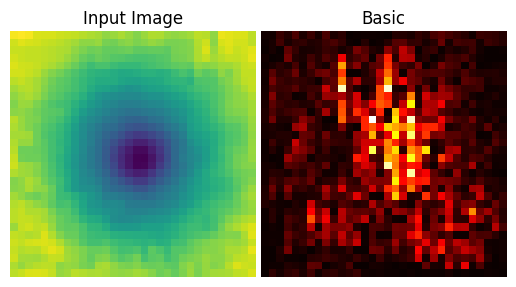

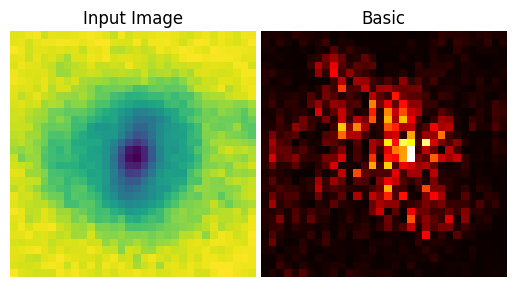

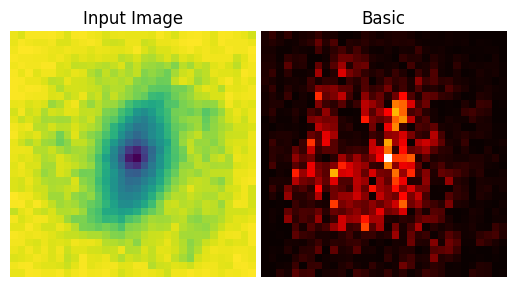

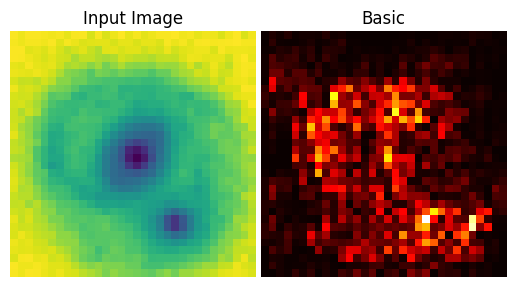

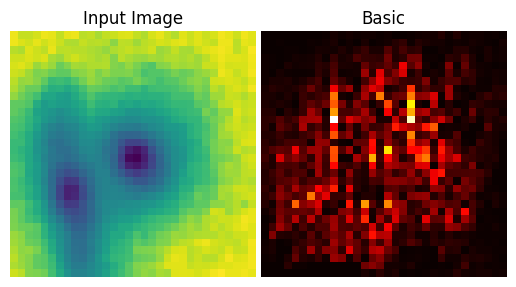

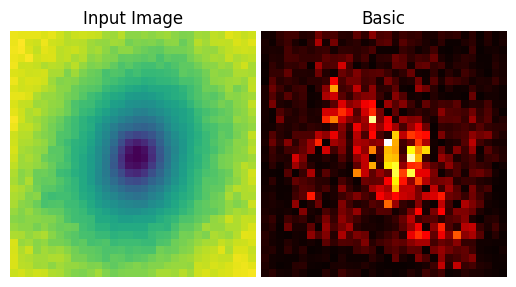

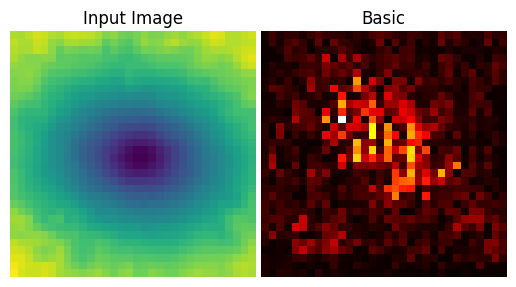

In [530]:
imgs, labels = next(iter(test_loader))
for i in np.arange(batch_size):
    map = vanilla_saliency(imgs[i], model)
    plot_saliency(imgs[i], [map])

The saliency maps look not-too-different in our 32x32 pixel image set, especially since our model is small and we trained it quickly. But we can begin to see the pixels that are used to determine the morphological classification of each galaxy. 

One of the limitations of these "vanilla' gradients for interpretability is that we're seeing the pixel gradients propagated through multiple hidden layers, so the gradients can cancel each other out. Further, the pixels with negative gradients show us features of the image that "suppress" network neurons. If we want to focus on what pixels had high importance for classification, we can zero out the negative gradients during backpropagation with a reLU function. This is called _guided backpropogation_ (Springenberg et al., 2015):

In [531]:
def relu_backward_hook_fn(module, grad_in, grad_out):
    return (torch.clamp(grad_in[0], min=0.0), )
    
def setup_hooks(model):    
    for module in model.modules():
        if type(module) == nn.ReLU:
            module.register_full_backward_hook(relu_backward_hook_fn)
    return model
    
def smoothgrad_saliency(input, model):
    # We don't need gradients with respect to the weights, so we can turn these off
    for param in model.parameters():
        param.requires_grad = False
    
    # Set model to evaluation mode
    model.eval()

    # We want to calculate gradients of the input,
    # so set requires_grad to True for input 
    input.requires_grad = True
    
    # Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    
    # Backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    slc = input.grad[0]
    return slc.numpy()

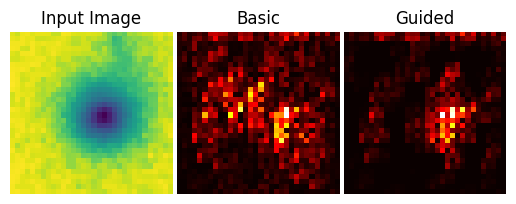

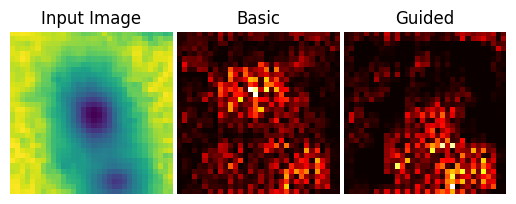

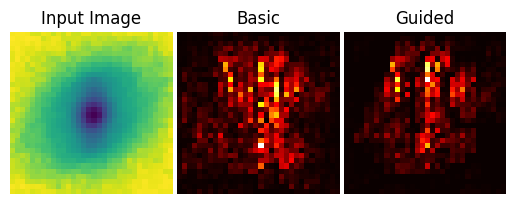

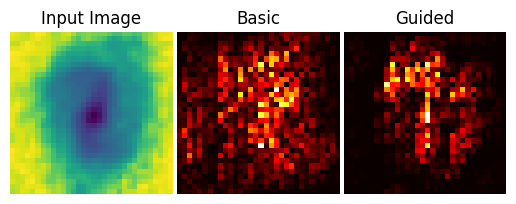

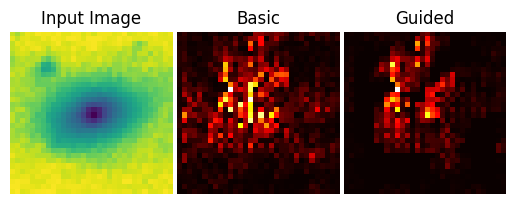

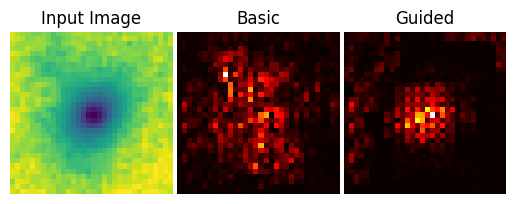

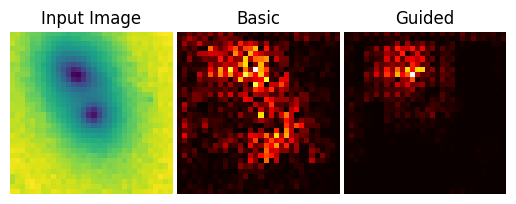

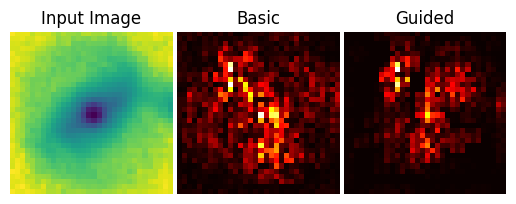

In [532]:
newModel = setup_hooks(copy.deepcopy(model))

imgs, labels = next(iter(test_loader))
for i in np.arange(batch_size):
    map1 = vanilla_saliency(imgs[i], model)
    map2 = guided_saliency(imgs[i], newModel)
    plot_saliency(imgs[i], [map1, map2])   

Potentially we do a *bit* better in some images, as we get rid of some of the more irrelevant pixels and focus in on some of the more significant ones. Across the two methods, the techniques still look pretty noisy. [Smilkov et al. (2017)](https://arxiv.org/pdf/1706.03825.pdf) propose that this is due to meaningless local variations in the calculated variations. Their `SmoothGrad` technique for reducing this noise is motivated by our earlier discussion of ensemble techniques, and is wonderfully simple: for an input image with pixels $x$, and calculated saliency map $M(x)$, a lower-noise saliency map can be calculated as...
$$
M'(x) = \frac{1}{n}\sum_1^n M(x + \mathcal{N}(0, \sigma^2))
$$

Create $n$ versions of the input image, add noise to each pixel from a distribution with variance $\sigma^2$, and average them.

## Question: Implement the SmoothGrad technique by modifying an earlier function. Explore different values of $\sigma$ and $n$ explore how this impacts the resulting saliency map.

In [533]:
def smoothgrad_saliency(input, model, sigma, N):
    # We don't need gradients with respect to the weights, so we can turn these off
    for param in model.parameters():
        param.requires_grad = False
    
    # Set model to evaluation mode
    model.eval()
    
    #add gaussian noise: 
    map_set = []
    total_gradients = torch.zeros(32, 32)
    for i in np.arange(N):
        GaussianMap = np.random.normal(loc=0.0, scale=sigma, size=(32, 32))
        GaussianTensor = torch.tensor(GaussianMap, dtype=torch.float32).unsqueeze(0)
        input_noisy = torch.add(input, GaussianTensor)

        # We want to calculate gradients of the input,
        # so set requires_grad to True for input 
        input_noisy.requires_grad = True  
        
        # Forward pass to calculate predictions
        preds = model(input_noisy)
        score, indices = torch.max(preds, 1)
        # Backward pass to get gradients of score predicted class w.r.t. input image
        score.backward()
        
        total_gradients += input_noisy.grad[0]
    return total_gradients / N

## 4.3.2. A comparison to SHAP values.

For comparison, I'll throw up the SHAP estimates for these pixels as well. This time, we'll only show the Shapley estimates for the class with the highest prediction for the model (same as is done for the gradient-based saliency maps).

In [534]:
# since shuffle=True, this is a random sample of test data
import shap 

background_size = 30
background_loader = DataLoader(test, shuffle=True, batch_size=background_size)
background_batch = next(iter(background_loader))
background_images, background_labels = background_batch

e = shap.DeepExplainer(model, background_images)
shap_values = e.shap_values(imgs)
shap_values = np.array(shap_values).squeeze()

In [535]:
preds = model(imgs)
score, indices = torch.max(preds, 1)

In [536]:
shap_values_max = []
for idx, chosenClass in enumerate(indices.numpy()):
    shap_values_max.append(shap_values[chosenClass, idx])

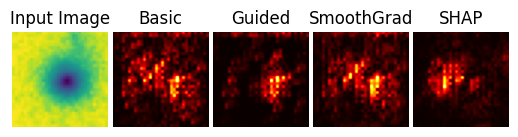

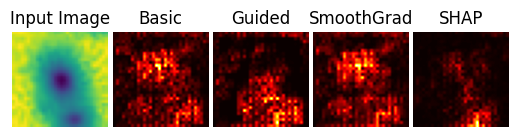

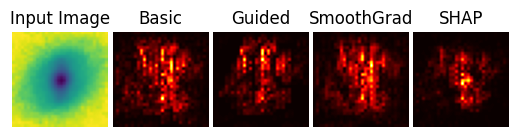

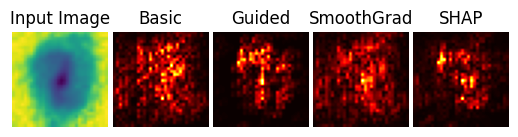

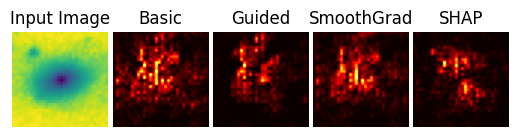

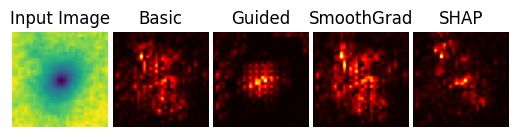

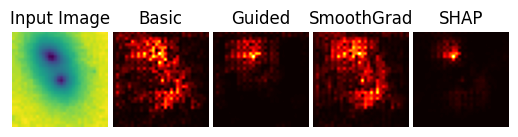

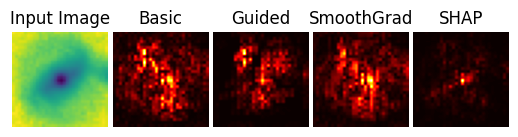

In [537]:
for i in np.arange(batch_size):
    map1 = vanilla_saliency(imgs[i], model)
    map2 = guided_saliency(imgs[i], newModel)
    map3 = smoothgrad_saliency(imgs[i], model, sigma=0.02, N=300)
    plot_saliency(imgs[i], [map1, map2, map3, shap_values_max[i]])   

Notice that because SHAP computes feature contribution relative to some background "baseline", it pulls out the anomalous features most clearly (like a bar, an off-center galaxy, etc). But these might not be all the features that the model uses for classification on other features! Gradients manage to present a more general picture of what a model uses for its prediction.

There are more complex pixel attribution techniques, but that's all we'll explore for now. In summary, there are global interpretability methods (like the permutation importance of gradient boosting) and local interpretability methods (like SHAP and counterfactuals). There are model-agnostic methods (like SHAP) and model-specific methods (like guided backpropagation for pixel attribution). Each of these presents a slightly different picture of your model. When used togther, they provide a powerful toolkit for understanding what's going on under the hood.

Beyond pixel attribution, there are several other methods that can be useful to better understand the behavior of a neural network. One is feature visualization, which tries to generate archetypes for what components of a neural network look for in an image. This is done by generating images that maximize the response of individual neurons, layers, or layer groups (shown here for the massive network GoogLeNet):

![](images/FeatureVisualization.png)

More information on feature visualization techniques can be found at [https://distill.pub/2017/feature-visualization/](). 